# Analyse descriptive de la base de données 

### Importation de la base

In [148]:
import pandas as pd 
import matplotlib.pyplot as plt
from functools import reduce
from operator import add
import spacy
from spacy import displacy
from spacy.tokenizer import Tokenizer
from spacy.lang.fr import French
from collections import Counter
import re
import fr_core_news_sm,fr_core_news_lg
nlp = fr_core_news_lg.load()

In [149]:
df = pd.read_csv("2019-01-08-editos-radio.csv")

On enlève les "\n" 

In [150]:
df['auteur'] = df['auteur'].apply(lambda x: " ".join(str(x).split()))

In [151]:
df['texte']= df['texte'].apply(lambda x: " ".join((str(x).split())))

### Statistiques descriptives textuelles

- Nombre de phrases 

In [5]:
def split(text, delimiters = [".","?","!","..."], maxsplit=0):
    #fonction servant juste à séparer les phrases dans un texte sous forme de liste
    delimiters = '|'.join(map(re.escape, delimiters))
    phrases = re.split(delimiters, text, maxsplit)
    return(list(filter(lambda a: a != '', phrases)))

In [6]:
def nombre_phrases(text):
    return(len(split(text)))

In [7]:
df['Nombre phrases'] = df['texte'].apply(nombre_phrases)

- Phrases interrogatives

In [8]:
df['Interrogatives'] = df['texte'].apply(lambda x : x.count('?'))
df['Pourcentage interrogatives']=round((df['Interrogatives']/df['Nombre phrases'])*100,2)
print("Proportion de phrases interrogatives : ", df['Pourcentage interrogatives'].mean(), '%')

Proportion de phrases interrogatives :  6.540354609929105 %


Est-ce notable ? A comparer.

#### Des différences stylistiques entre les éditorialistes ?

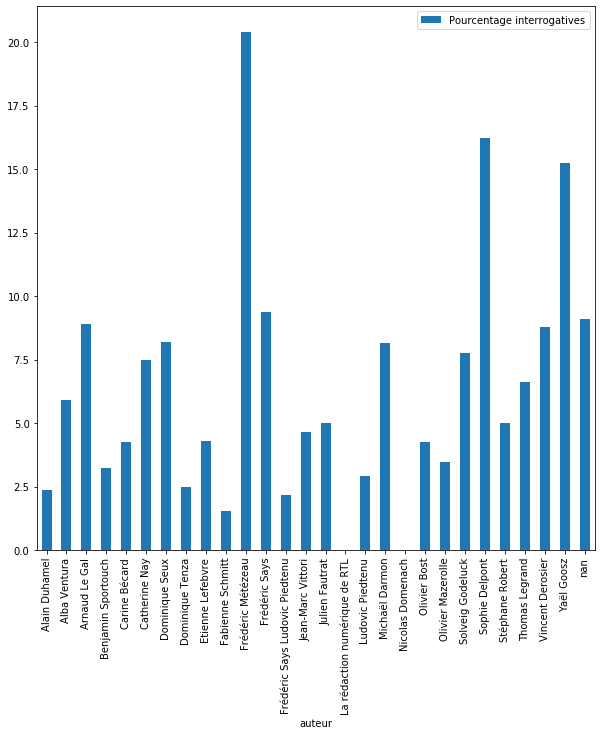

In [18]:
pd.DataFrame(df.groupby('auteur').mean().reset_index()).plot.bar(x='auteur', y='Pourcentage interrogatives', figsize=(10,10))

- Repères (lieux, personnes)

In [9]:
def counter_label(text,label):
    doc=nlp(text)
    c=0
    for ent in doc.ents:
        if ent.label_ == label:
            c+=1
    return(c)

In [10]:
df['Lieux'] = df['texte'].apply(lambda x: counter_label(x,'LOC'))

KeyboardInterrupt: 

In [21]:
df['Personnes'] = df['texte'].apply(lambda x: counter_label(x,'PER'))

In [22]:
df['Lieux par phrase'] = round((df['Lieux']/df['Nombre phrases']),2)
df['Personnes par phrase'] = round((df['Personnes']/df['Nombre phrases']),2)

- Chiffres / Pourcentage

In [27]:
df['Pourcentages'] = df['texte'].apply(lambda x : x.count('%'))
df['Pourcentages par phrase'] = round((df['Pourcentages']/df['Nombre phrases']),2)

In [40]:
Histoire=['l\'ancien président','l\'ancien ministre', 'autrefois', 'précédente élection','dernière campagne','précédent mandat',
         'à une autre époque',]

#### Personnalités politiques 

Afin de reveler les personnalités politiques citées dans un édito, on crée une liste composées des présidents et ministres de la
Ve République à laquelle on a rajouté les députés et sénateurs en activité, puis les eurodéputés élus en 2019 ainsi que les candidats à la présidentielle de 2017.

In [156]:
%run Scrap_perso_politiques_Fr.ipynb

Première manière de faire:

In [128]:
def personalite_politique(text):
    doc = nlp(text)
    Reference=[]
    c=0
    # Itère sur les ENT du doc
    for ent in doc.ents:
        if str(ent) in Presidents:
            Reference+=[ent]
            c+=1
        elif str(ent) in Ministres_Ve:
            Reference+=[ent]
            c+=1
        elif str(ent) in Deputes:
            Reference+=[ent]
            c+=1
    return[Reference,c]

In [169]:
test='Le second tour opposera Sarkozy à Ségolène Royal, Jean-Luc Mélenchon a été battu'
#personalite_politique(test)

On remarque que qu'il faut le nom complet d'une personnalité pour que la référence soit relevée(résolu).

In [31]:
#df['Personalités politique'] = df['texte'].apply(lambda x : personalite_politique(x)) 

In [47]:
#df['Personalités_po par phrase']= round((len(df['Personalités politique'][0])/df['Nombre phrases']),2)

2e manière : un Phrase matcher de SpaCy

In [157]:
POLITICIANS = Ministres_Ve + Presidents + Deputes + Senateurs + eurodeputes + Candidats_2017
POLITICIANS += ['JL Mélenchon', 'Marine le Pen', 'J.L. Mélenchon', 'JL. Mélenchon', 'Benoit Hamon']

# On importe le PhraseMatcher et on l'initialise
from spacy.matcher import PhraseMatcher
matcher_politician = PhraseMatcher(nlp.vocab)

# On crée des motifs objets et  on les ajoute au matcher

patterns = list(nlp.pipe(POLITICIANS))
matcher_politician.add("Politicians", None, *patterns, on_match=True)

In [162]:
# Appelle le matcher sur le document de test et affiche le résultat
essai = nlp(" François Hollande devrait s'appuyer sur Michel Sapin et son expérience. François Hollande contre Gérard Larcher,Mélenchon")
matches_essai = matcher_politician(essai)
print([[essai[start:end] for match_id, start, end in matches_essai],len(matches_essai)])

[[François Hollande, Michel Sapin, François Hollande, Gérard Larcher], 4]


- Si le nom d'un politique n'apparait pas en entier il n'est pas relevé par le Matcher. (résolu)
- En ajoutant les noms seuls, à la liste des noms prénoms, on a un problème pour les entités qui se chevauchent (Hollande dans François Hollande) (résolu)
- Le matcher relève le nom d'une personnalité politique autant de fois qu'elle est citée, si on s'intéresse aux nombres de citations
différentes on mettra un *set()*

In [171]:
def expressions_extraction(texte,matcher):
    doc = nlp(texte)
    matches = matcher(doc)
    return([doc[start:end] for match_id, start, end in matches])

In [173]:
expressions_extraction(test,matcher_politician)

[Ségolène Royal, Jean-Luc Mélenchon]

##### Création d'une nouvelle entité nommée : Politicien (POL)

In [164]:
from spacy.tokens import Span

def politician_component(doc):
    # Crée une entité Span avec le label "POL" pour toutes les correspondances
    matches = matcher_politician(doc)
    doc.ents = [Span(doc, start, end, label='POL') for match_id, start, end in matches]
    return doc


# Ajoute le composant au pipeline
nlp.add_pipe(politician_component, before='ner')
print(nlp.pipe_names)

['tagger', 'parser', 'politician_component', 'ner']


On ajoute le composant à la recherche des noms de familles de politiciens.

In [165]:
POLITICIANS_surname = [politicien.split()[-1] for politicien in POLITICIANS]

def politicians_surnames(doc):
    new_ents = []
    for ent in doc.ents:
            if ent.text in POLITICIANS_surname:
                new_ent = Span(doc, ent.start, ent.end, label='POL')
                new_ents.append(new_ent)
            else:
                new_ents.append(ent)
    doc.ents = new_ents
    return doc

nlp.add_pipe(politicians_surnames, after='ner')
print(nlp.pipe_names)

['tagger', 'parser', 'politician_component', 'ner', 'politicians_surnames']


In [27]:
df['Politiques'] = df['texte'].apply(lambda x: counter_label(x,'POL'))

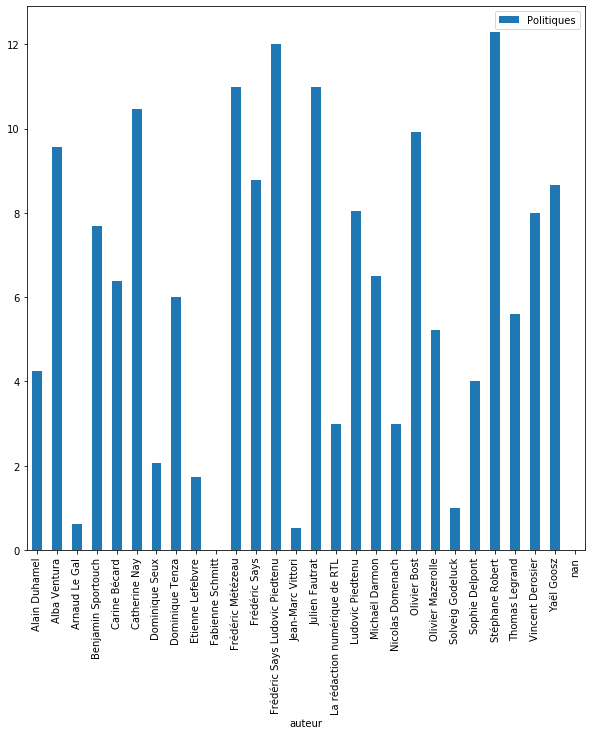

In [28]:
pd.DataFrame(df.groupby('auteur').mean().reset_index()).plot.bar(x='auteur', y='Politiques', figsize=(10,10))

On note d'importante disparités dans l'évocation de figures politiques (Présidents, ministres (actuels et anciens), députés, eurodéputés, sénateurs, candidats à la présidentielle 2017)

#### Utilisation d'un matcher, pour trouver des expressions.
- Ici on veut repérer la citation d'un rapport ou d'une étude

In [174]:
from spacy.matcher import Matcher
matcher_rapport = Matcher(nlp.vocab)

# On écrit un motif pour le mot rapport et les mots qui le suivent habituellement
pattern = [{"lower": "rapport"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "PROPN", "OP":"+"}]
pattern_date=[{"lower": "rapport"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "PROPN", "OP":"?"},
           {"POS": "ADP", "OP":"?"},{"POS": "NUM","OP":"+"}]
pattern_theme = [{"lower": "rapport"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "NOUN", "OP":"+"}]

# On reprend les mêmes motifs pour une étude
pattern_etude = [{"lower": "étude"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "PROPN", "OP":"+"}]
pattern_etude_date=[{"lower": "étude"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "PROPN", "OP":"?"},
           {"POS": "ADP", "OP":"?"},{"POS": "NUM","OP":"+"}]
pattern_etude_theme = [{"lower": "étude"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "NOUN", "OP":"+"}]

# Ajoute les motifs au matcher et applique le matcher au doc
matcher_rapport.add("Rapport_PATTERN", None, pattern)
matcher_rapport.add("Rapport_PATTERN_date",None,pattern_date)
matcher_rapport.add("Rapport_PATTERN_date",None,pattern_theme)
matcher_rapport.add("Etude_PATTERN", None, pattern_etude)
matcher_rapport.add("Etude_PATTERN_date",None,pattern_etude_date)
matcher_rapport.add("Etude_PATTERN_date",None,pattern_etude_theme)

In [175]:
# Un essai
doc=nlp('Le rapport sur le Climat, Un rapport de 2014, Une étude sur les Gilets Jaunes, Le rapport Borloo, Le rapport Borloo 2019, Le rapport du GIEC, Le rapport de Jean-Louis Borloo, Le rapport du FMI 2012, un rapport de 2012')
matches = matcher_rapport(doc)
print("Nombre de correspondances trouvées :", len(matches))

for match_id, start, end in matches:
    #print("Correspondance trouvée :", doc[start:end].text)
    print(str(doc[start:end]))

Nombre de correspondances trouvées : 12
rapport sur le Climat
rapport de 2014
étude sur les Gilets
rapport Borloo
rapport Borloo
rapport Borloo 2019
rapport du GIEC
rapport de Jean-Louis
rapport de Jean-Louis Borloo
rapport du FMI
rapport du FMI 2012
rapport de 2012


Note: On veut supprimer les expressions qui sont contenues dans d'autres expressions identifiées par le matcher

In [25]:
# Une ébauche de cleaner

#def clear_matcher(matches):    
    #for match_id, start, end in matches:
        #index= matches.index((match_id,start,end))
        #for matchid, debut, fin in matches[:index]+matches[index+1:]: 
            #if str(doc[start:end]) in str(doc[debut:fin]):
                #matches.remove((match_id, start, end))
    #return(matches)

In [176]:
def clear_matcher(matches):
    liste_clear=[]
    for i in range(len(matches[:-1])):
        match_id, start, end = matches[i]
        machid, debut, fin = matches[i+1]
        if not str(doc[debut:fin]).startswith(str(doc[start:end])):
            liste_clear+=[str(doc[start:end])]
    return(liste_clear)

In [177]:
clear_matcher(matches)

['rapport sur le Climat',
 'rapport de 2014',
 'étude sur les Gilets',
 'rapport Borloo 2019',
 'rapport du GIEC',
 'rapport de Jean-Louis Borloo',
 'rapport du FMI 2012']

In [178]:
def match_rapport(text):
    doc=nlp(text)
    matches = matcher_rapport(doc)
    return(clear_matcher(matches),len(clear_matcher(matches)))

In [179]:
test='Le rapport sur le Climat, Une étude sur les Gilets Jaunes, Le rapport Borlo, Le rapport Borlo 2019, Le rapport du GIEC, Le rapport de Jean-Louis Borlo, Le rapport du FMI 2012, un rapport de 2012'
match_rapport(test)

(['rapport sur le Climat',
  'rapport de 2014,',
  'les Gilets',
  'Le rapport Borloo',
  'rapport Borloo 2019',
  'rapport du GIEC,',
  'de Jean-Louis Borloo,'],
 7)

In [58]:
#df.to_csv('Editos-radio_Analyse.csv.csv', index=False)

### Mise en exergue des entités nommées dans un texte

In [21]:
Legrand = df[df['auteur']=='Thomas Legrand']
Legrand = Legrand.reset_index()

Seux = df[df['auteur']=='Dominique Seux']
Seux = Seux.reset_index()

In [146]:
texte=nlp(Seux['texte'][11])
displacy.render(texte, style='ent')

# Entraînement d'un nouveau modèle 

In [91]:
# Crée un modèle "en" vide
nlp_date = spacy.blank("fr")

# Crée un nouvel entity recognizer et ajoute-le au pipeline
ner = nlp_date.create_pipe("ner")
nlp_date.add_pipe(ner)

# Ajoute le label "DATE" à l'entity recognizer
ner.add_label("DAT")

In [127]:
#("phrase", {"entities": [(15, 24, "LABEL")]},)

TRAINING_DATA = [
    ("Nous sommes en 2021", {'entities': [(15, 19, 'DAT')]},),
    ('En sciences sociales comme en sciences la démarche se veut scientifique', {'entities': []},),
    ('La dernière coupe du monde à eu lieu en 2018', {'entities': [(40, 44, "DAT")]},),
    ('Il faut comprendre que 2014 est une date', {'entities': [(23, 27, "DAT")]},),
    ('Le 19 octobre 2019, j\'ai eu 20 ans', {'entities': [(3, 18, 'DAT' )]},),
    ('La  culture de Soja détruit la forêt amazonienne', {'entities': []},),
    ('Le Premier ministre adressera ses voeux aux français le 27 Janvier', {'entities': [(56,66, 'DAT')]},),
    ('L\'année 1933 Adol Hitler a été élu Chancelier d\'Allemagne', {'entities': [(8, 12, 'DAT')]},),
    ('Les éléctions européennes de 2019 ont confirmé la bonne dynamique des partis écolos', {'entities': [(29, 33, 'DAT')]},)
]

In [128]:
len('L\'année 1933')
'l\'année 1933'[8:12]

'1933'

In [129]:
import random 

# Commence l'apprentissage
nlp_date.begin_training()

# Boucle pour 20 itérations
for itn in range(20):
    # Mélange les données d'apprentissage
    random.shuffle(TRAINING_DATA)
    losses = {}

    # Répartis les exemples en lots et itère dessus
    for batch in spacy.util.minibatch(TRAINING_DATA):
        texts = [text for text, entities in batch]
        annotations = [entities for text, entities in batch]

        # Actualise le modèle
        nlp_date.update(texts, annotations, losses=losses)
    print(losses)

{'ner': 3.593495143907675e-15}
{'ner': 1.7026498935555848e-15}
{'ner': 9.58089724399704e-16}
{'ner': 6.900062769853091e-16}
{'ner': 4.910405409975596e-16}
{'ner': 4.4054115940722274e-16}
{'ner': 4.264395357994734e-16}
{'ner': 4.570458262620127e-16}
{'ner': 5.241283047157466e-16}
{'ner': 6.260246541218143e-16}
{'ner': 8.389692751734323e-16}
{'ner': 9.775718631457478e-16}
{'ner': 1.1261563051190924e-15}
{'ner': 1.2617817203585054e-15}
{'ner': 1.3685173400333153e-15}
{'ner': 1.4306107903673663e-15}
{'ner': 1.4627618477231358e-15}
{'ner': 1.464891218156839e-15}
{'ner': 1.5391484812633774e-15}
{'ner': 1.5523349474436844e-15}


In [138]:
doc=nlp_date('En 2017 François Hollande ne s\'est pas présenté en économie ? mais peut être va-t-il faire un retour en 2022. On le saura le 13 Février.')
nlp_date.pipe_names

['ner']

In [139]:
doc.ents

(2017, 2022, 13 Février, .)

In [140]:
texte=nlp(Seux['texte'][14])
displacy.render(texte, style='ent')